## Analysis of Hollywood Evolution

How does the hollywood network look like and how has it changed over time

In this section we will dive into the network and explore different attributes of the network, to gain insights on the elite of Hollywood. This will be structured into the 6 subsections listed below.

* Investigation of the network - Get at reference point to some of the well known and documented networks
    * [x] Links
    * [x] In and out degree
    * [x] Visualisation of the entire network with relevant attributes - SHOULD BE IMPROVED
    * [ ] Comparison with Random Network
    * [ ] Changes in degree distribution over time
    
* Genre - How are the top of Hollywood distributed across genres
    * [x] Genre distribution over time
    * [x] Genre popularity compared to average budget
    * [ ] Particular patterns of actors work in genres - Asbjørn

* Important words - What words stand out using TF-IDF schemas of the decades and across genres and decase
    * [x] TF-IDF
    * [x] Relation to dominant genres
    * [x] Wordclouds
    * [ ] Most important words -> similarity with the decades wikipedia page

* Sentiment - How do people interpet the words of these segmentations?
    * [ ] How does it relate to the TF-IDF
    * [ ] Does it reflect the major events of the us/world?

* Actor communities - What actors constitute movie communities and how has this changes over time?
    * [ ] Are the communities high budget highly rated?

* Wrapup - Can we generalize the trends in hollywood?


In [1]:

from IPython.display import Image, clear_output
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import re
import nltk
import json
import bar_chart_race as bcr
import random
import json
from collections import Counter, defaultdict
import urllib
from datetime import datetime
from ipywidgets import *
import ipywidgets as widgets
import time
import math
from nltk.corpus import stopwords
from PIL import Image
import seaborn as sns
from pandas.core.common import SettingWithCopyWarning
import warnings
import copy
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)



#Init stopwords
stop_words = set(stopwords.words('english'))

In [2]:
try:
    from fa2 import ForceAtlas2
    from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
    import gif
except:
    pass

In [3]:
%run -i 'Jupyter/helpers.py'

In [4]:
df, G = create_df_G_from_path('')

### Network investigation
To gain deeper insight into our network we will start off by letting the data talk

In [ ]:
# ANALYSIS
print(f"Number of nodes in network: {G.number_of_nodes()}")
print(f"Number of links (edges) in network: {G.number_of_edges()}")
print(f"Average number of links per node: {round(G.number_of_edges()/G.number_of_nodes(),2)}")
print(f"Average shortes path: {round(nx.algorithms.average_shortest_path_length(G),4)}")

In [ ]:
in_degree = sorted([(d,n) for n, d in G.degree()], reverse=True)
print('Top 5 most connected characters (movies, Actor)')
print(*in_degree[0:5], sep='\n')

From the above we see that the network is very highly connected with every node on average connecting to 36.44 other actors and an average shortest path only being 1.85. Relating this to the small world phenomenon known as six degrees of separation, which refeers to "two individuals, anywhere in the world, can be connected through a chain of six or fewer acquaintances"[\[1\]](http://networksciencebook.com/chapter/3#small-worlds), this network already by itself a community relating it to the larger population

From the data it looks like the actors are contributing to a very similiar amount of movies, which could lead one to believe that the network amongst the top 500 does not follow a **power law distribution** 

Lets take a look at this along, with the productivity over time for the actors

In [ ]:
# Degree
degree = sorted(G.degree, key=lambda x: x[1], reverse=True)
# Splitting the sequence
degree_sequence = sorted([d for n, d in degree], reverse=True)
# Creating the histogram bins and counts
hist, bin_edges = np.histogram(np.array(degree_sequence), bins=np.arange(degree[-1][1], degree[0][1]+2))

# For the barplot
degreeCount = Counter(degree_sequence) # Count the degrees
deg, cnt = zip(*degreeCount.items()) # deg: degree, cnt: the count of the degree


In [ ]:
# Plot:
fig, axarr = plt.subplots(1, 2, figsize=(16,8))
fig.suptitle("Degree distribution", fontsize=16)

axarr[0].bar(deg,cnt,color='dodgerblue')
axarr[0].set_xlabel('Degree')
axarr[0].set_ylabel("Frequency")
axarr[0].set_xlim([-3,max(deg)+10])
axarr[0].set_title("Histogram of degree distribution")

axarr[1].loglog(bin_edges[:-1],hist,'.', color="mediumseagreen")
axarr[1].set_xlabel('Degree')
axarr[1].set_ylabel("Frequency")
axarr[1].set_title("Degree distribution (Log-Log)")

fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

In [ ]:
# Reverse lookup for speed increase
reverse_movie_year_lookup={}
for row in df.iterrows():
    if pd.isna(row[1]['release_date']):
        continue
    reverse_movie_year_lookup[row[1]['original_title']] = row[1]['release_date']

#Extract data
relase_data = []
for node in G.nodes:
    actor_movies = sorted([reverse_movie_year_lookup[x].year for x in G.nodes[node]['movies']])
    first_release = min(actor_movies)
    actor_movies = [x-first_release for x in actor_movies]
    relase_data.append((node, actor_movies, [x for x in range(1,len(actor_movies)+1)]))
    
    

In [ ]:
limit=7
l_relase_data=len(relase_data)
relase_data=sorted(relase_data, key=lambda x: len(x[1]), reverse=True)[0:limit]+sorted(relase_data, key=lambda x: len(x[1]), reverse=True)[l_relase_data-limit:l_relase_data]
fig, ax = plt.subplots(figsize=(15, 6))
for i in range(len(relase_data)):
    l_postfix=' TOP'
    if i>=limit:
        l_postfix=' BOTTOM'
    ax.plot(relase_data[i][1], relase_data[i][2], label=relase_data[i][0]+l_postfix,linewidth=3)
ax.set_ylim(1)
ax.set_ylabel('Movies')
ax.set_xlabel('Years since first production')
plt.title(f'Actor productivity since first hollywood production - top and bottom: {limit}')
plt.legend()
plt.show()

This seems to validate our assumption of the network to not follow a powerlaw distribution. The data semmes normal distributed around 65 with a slight right skewness, though not completely. The initial analysis of this plot would lead one to belive that there can be actually quite a large gap between the top and bottom actors. There might be, but the distribution plot removes the focus from the fact that some actors have been much longer in the business, and therefore have had more time to produce movies. For this the actor productivity provides alot more information about what the differences are between the actors productivity.

The plot of actor productivity seems to a story along the same lines, that even between **the top 500 Actors** there are quite a big diffenrence in productivity between the top and bottom. Samuel L. Jackson has produced around 20 movies pr. decade while Michael McKean produces around 6 in the first 20 years

**Overvejelse om dette skal fjernes**
Relating this to the movies industry we also know that some actors can produce very large amount in a short time without great imdb scores where as others work on slower productions with a higher focus on production values.

### Visual representation of the network

Lets take a look at the full network sizing the actors after productivity, coloring after most common genre, and letting opacity of edges reflect how much two actors have worked together

In [ ]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        edgeWeightInfluence=0.6,

                        # Performance
                        jitterTolerance=0.15,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=0.7,

                        # Tuning
                        scalingRatio=4.0,
                        strongGravityMode=True,
                        gravity=1.0,

                        # Log
                        verbose=True)

In [ ]:
#@gif.frame
def weight_color_map(weight, inverse_color=False):
    inv_fac=0
    if inverse_color:
        inv_fac=1
    get_tuple = lambda x: tuple(abs(inv_fac-x) for y in range(3))
    
    # Low weight edge
    if weight<2:
        
        #white
        if not inverse_color:
            (1,0,0)
        return get_tuple(0.9)
    # Mid weight edge
    elif weight <5:
        
        return get_tuple(0.6)
    # mid-high weight edge
    elif weight <7:
        # Green
        return (0.3, 0.8, 0)
    # High weight edge
    else:
        # Dark red
        return (1, 0, 0)
    
    
def plot_graph(G, actor_label_movie_limit=40, inverse_color=False):
    color_map = {}
    for genre in list(set([G.nodes[x]['top_genre'] for x in list(G.nodes)])):
        color_map[genre] = []

    for node in G.nodes:
        color_map[G.nodes[node]['top_genre']] += [node]
    fig, ax = plt.subplots(figsize=(18,16))

    positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=5)
    
    color = {'Action': 'Red', 'Adventure': 'Blue', 'Animation': 'Pink', 'Comedy': 'Green', 'Crime': 'Brown',\
          'Drama': 'Cyan', 'Family': 'Yellow', 'Thriller' : 'White', 'Romance': 'Orange', 'Science Fiction': 'Black'}
    # Inverse
    node_label_color = 'black'
    if inverse_color:
        node_label_color='white'
    
    
    
    # Missing node sizing
    for key in color_map.keys():
        nx.draw_networkx_nodes(G,pos=positions,nodelist=color_map[key],\
            node_size=[int(G.nodes[x]['movies_count'])*2 for x in color_map[key]], node_color=color[key], label=key, ax=ax)
        #[G.degree(y) for y in color_map[key]]
    
    colormap_edges = [weight_color_map(G[u][v]['weight'], inverse_color) for u,v in G.edges]
    nx.draw_networkx_edges(G, positions, edge_color=colormap_edges, alpha=0.4, ax = ax,width=2)
    ax.legend(scatterpoints = 1)
    nx.draw_networkx_labels(G, positions,{y:'' if G.nodes[y]['movies_count']<actor_label_movie_limit else y for y in positions.keys()}, font_size=14, font_color=node_label_color, ax = ax)
    ax.axis('off')
    title_obj = ax.set_title('Top 500 Actors \n Colored after most common genre, sized after total feature films')
    plt.setp(title_obj, color='white') 
    plt.setp(title_obj, fontsize=15) 

    if inverse_color:
        ax.set_facecolor('black')
        fig.set_facecolor('black')
    return ax

In [ ]:
ax = plot_graph(G, actor_label_movie_limit=35, inverse_color=True)
plt.show()

From the above plot we see that there seem to be an overweight of actors acting within the genres of Comedy and Drama. As the connection degree so high it's a bit difficult to see what is going on, but we see that there definitly are some central noedes in the network.

**Sig lidt mere og forbedre graf**
* Tilføj nodesize
* Find en smart måde ikke at plotte edges der er under 2 etc.

## <span style="color:red">Remove before final version</span>

### Create GIF

In [ ]:
gif.options.matplotlib["dpi"] = 800

In [ ]:
rand_neighbors = []

for i in range(20):
    n1 = np.random.randint(low = 20, high = 40)
    n2 = np.random.randint(low = 5, high = 8)
    n = list(G.neighbors('Samuel L. Jackson'))[n1:n1+n2] + ['Samuel L. Jackson']
    rand_neighbors += [n]

In [ ]:
%%capture
frames = []
for n in rand_neighbors:
    frame = plot_graph(G.subgraph(n))
    frames.append(frame)

In [ ]:
gif.save(frames, 'network.gif', duration=40, unit="s", between="startend")

### End GIF

## Genre

Now that we have a basic understanding of the network we can start taking a look at how the movie distribution looks across genres. In the network plot we saw a larger overweight of drama and comedy actors, but this the based on their most common genre. Even if there is only a small differece in number of total genre features.

In [ ]:
# Has there been a large change in the most popular genre
df.sort_values('release_date', inplace=True)

movie_genre={}
for x in df.iterrows():
    movie_genre[x[1]['original_title']]=[y['name'] for y in json.loads(x[1]['genres'])]


genres=set([y for x in movie_genre.values() for y in x])
data = defaultdict(lambda: defaultdict(int))

for x in df.iterrows():
    for y in json.loads(x[1]['genres']):
        data[x[1]['release_date'].year][y['name']]+=1
# Set missing values
for k in data.keys():
    missing_k=genres.difference(set( x for x in data[k].keys()))
    for genre in missing_k:
        data[k][genre]=0

**Interactive plot only avaliable locally**
Below we can interact with horizontal bar plot showing genre activity across the different years.

In [ ]:
%matplotlib inline
plt.ioff()
np.random.seed(19680801)
plt.rcdefaults()
y_pos = np.arange(len(genres))
# Get names a lazy way
genres_ = [x[0] for x in sorted(data[2000].items())]
colors = np.random.rand(len(genres),3)
ax.set_yticks(y_pos)
ax.set_yticklabels(genres_)
ax.set_xlabel('Movie Count')
ax.set_title('Genre distribution')


def update(year):
    performance = [x[1] for x in sorted(data[year].items())]
    plt.barh(y_pos, performance, align='center', color=colors)
    plt.xlabel('Movie Count')
    plt.title('Genre distribution')

interact(update, year = data.keys());

Invesitgating for different years we see that in the early period of dataset - before 1970 - there is not a lot of datapoints. Lets plot a small movie to see how it changes from beginning to of data

In [ ]:
# Multiple plots shown as a movie

%matplotlib inline
np.random.seed(19680801)
plt.rcdefaults()

cumm=True

# Example data
y_pos = np.arange(len(genres))
colors = np.random.rand(len(genres),3)
#lazy init
labels_=[x[0] for x in sorted(data[2000].items())]

cumm_data=np.zeros(len(labels_))
for year in data.keys():    
    performance = [x[1] for x in sorted(data[year].items())]
    cumm_data+=performance
    if cumm:
        performance=cumm_data
    plt.barh(y_pos, performance, align='center', color=colors)
    plt.xlabel('Performance')
    plt.yticks(y_pos,labels_)
    plt.title(f"Distribution of Genres Year: {year}")
    plt.show()
    time.sleep(0.1)
    clear_output(wait=True)

From the above plot we see that drama seems to have been the main genre since the begining of the dataset. Something else that stands out is the rise of popularity of especially comedy and thrillers in the 1990 and onwards. This might be due to the rise of sitcoms such as Friends and Seinfield, which might also have brought the genres into the theaters. To verify or reject this hypotesis, is obvius to the a look at development in genre budgets over time. This has been plotted below

In [ ]:
# Generate budget data
data_budget = defaultdict(lambda: defaultdict(list))

for x in df.iterrows():
    for y in json.loads(x[1]['genres']):
        data_budget[x[1]['release_date'].year][y['name']].append(x[1]['budget'])
# Set missing values
for k in data_budget.keys():
    missing_k=genres.difference(set( x for x in data_budget[k].keys()))
    for genre in missing_k:
        data_budget[k][genre]=[0]
        

In [ ]:
for year in data_budget.keys():    
    performance = [x[1] for x in sorted(data_budget[year].items())]
    break

In [ ]:
# Multiple plots shown as a movie

%matplotlib inline
np.random.seed(19680801)
plt.rcdefaults()

cumm=True

# Example data
y_pos = np.arange(len(genres))
colors = np.random.rand(len(genres),3)
#lazy init
labels_=[x[0] for x in sorted(data[2000].items())]

cumm_data=np.zeros(len(labels_))
for year in data.keys():    
    performance = [x[1] for x in sorted(data_budget[year].items())]
    performance = [np.mean(x) if x else 0 for x in performance]
    if cumm:
        # Update cumm mean
        for i in range(len(performance)):
            val = performance[i]
            if val:
                cumm_data[i]=(cumm_data[i]+val)/2
        performance=cumm_data
    plt.barh(y_pos, performance, align='center', color=colors)
    plt.xlabel('Budget')
    plt.xlim((0,2e8))
    plt.yticks(y_pos,labels_)
    if not cumm:
        plt.title(f"Distribution of Genres Budgets for year: {year}")
    else:
        plt.title(f"Distribution of Genres Budgets for year cumulative: {year}")
    plt.show()
    time.sleep(0.1)
    clear_output(wait=True)

What we see above is as expected an increase in the average budget size from the 1990 and onwards to the aboce mentioned genres, but this actually happends across the line which makes it difficult to distinguish any of the patterns indicated in the genre count distrbution. 

#### Patterns of actors work within genres

Having explored the general pattern of the evolution of genres through time, it is now interesting to see if this also shows when investigating individual actors.

It is naturally expected that actors generally star in comedy movies more often, in the latest decade. Therefore we investigate whether some actors experience a steep rise in comedy movie apperances.

## <span style="color:red">Insert Asbjørns plots on actor development</span>

In [5]:
actors_per_movie = df['cast'].apply(lambda x: ','.join(re.findall(r'"name": "(\w+ \w+)"', x))).str.split(',', expand = True).fillna('')
actors_per_movie = df[['original_title', 'id']].merge(right = actors_per_movie, left_index = True, right_index = True)

actors_per_movie = actors_per_movie.melt(id_vars=['original_title', 'id'])
actors_per_movie = actors_per_movie[actors_per_movie['value'] != '']

In [6]:
df_1 = copy.deepcopy(df)
df_1.sort_values('release_date', inplace=True)
df_1.reset_index(inplace=True)
df_1['year'] = pd.DatetimeIndex(df_1['release_date']).year

In [7]:
genre_set = set()

for i in df_1.index:
    dict_ = json.loads(df_1['genres'].loc[i])
    for j in dict_:
        genre_set.add(j['name'])

In [8]:
genre_dict = dict(zip(genre_set, np.arange(0,len(genre_set))))
inv_genre_dict = {v: k for k, v in genre_dict.items()}

In [9]:
def actorGenres(actor):
    
    movies = list(actors_per_movie['original_title'][actors_per_movie['value']==actor])
    
    genres_list = np.zeros((len(movies),len(genre_dict)))
    cum_genres_list = np.zeros((len(movies),len(genre_dict)))
    year_list = np.zeros(0)
    
    index = 0
    
    prev_genre_list = np.zeros(len(genre_dict))
    for i in df_1['genres'][df_1['original_title'].isin(movies)].index:
        year_list = np.append(year_list,df_1['year'].loc[i])
        genres = json.loads(df_1['genres'][df_1['original_title'].isin(movies)].loc[i])
        for j in genres:
            genres_list[index][genre_dict[j['name']]] += 1
        
        cum_genres_list[index] = np.add(prev_genre_list, genres_list[index])
        prev_genre_list = cum_genres_list[index]
        index += 1
    
    
    return year_list, genres_list, cum_genres_list

In [10]:
def actorDevPlot(actor,cum=True):
    
    if not G.has_node(actor):
        print("Actor not in network")
        return
    
    actor_gen = actorGenres(actor)
    
    if cum:
        genres = actor_gen[2]
    else:
        genres = actor_gen[1]
    
    fig, ax = plt.subplots(figsize=(15, 6))
    
    
    for i in range(len(genre_dict)):
        ax.plot(actorGenres(actor)[0], genres[:,i], label=inv_genre_dict[i], linewidth=3)
        ax.annotate(inv_genre_dict[i], xy=(actor_gen[0][-1], genres[len(genres)-1,i]))
        
    ax.set_ylim(1)
    ax.set_ylabel('Movies')
    ax.set_xlabel('Year')
    
    if (actor[-1]!='s'):
        ax.set_title(actor + "'s career in genres")
    else:
        ax.set_title(actor + "' career in genres")
        
    plt.legend()
    plt.show()

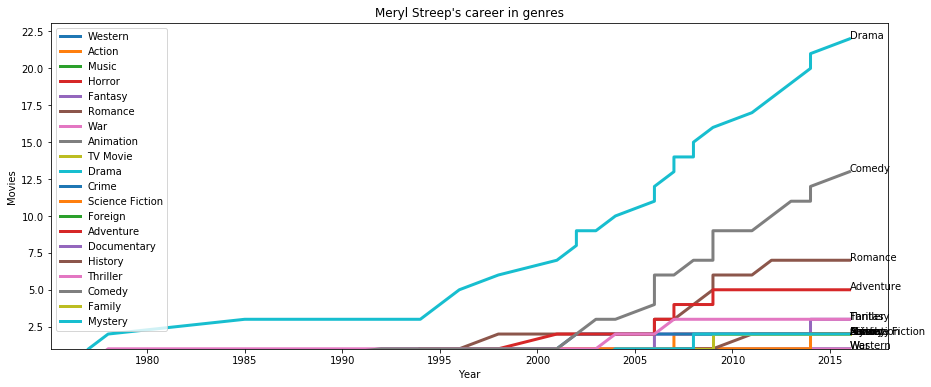

In [11]:
actorDevPlot('Meryl Streep')

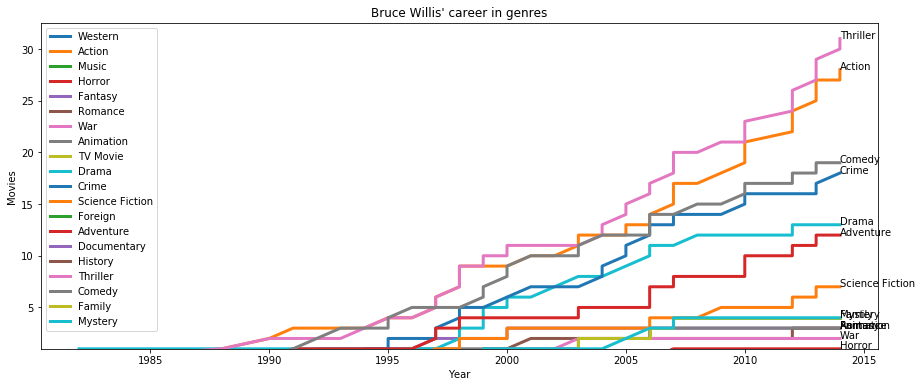

In [12]:
actorDevPlot('Bruce Willis')

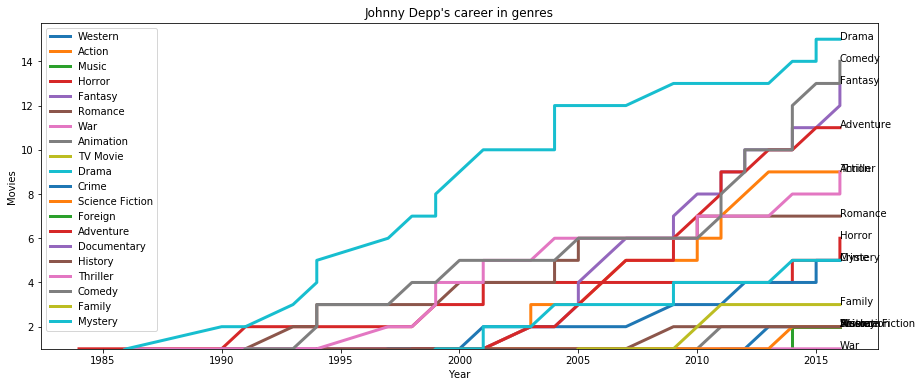

In [13]:
actorDevPlot('Johnny Depp')

Both Meril Streep's and Johnny Deep's career has experienced an exponential growth in comedy appearances, which supports the behaviour we expected in general. However, Bruce Willis has a more linear tendency, which means he basically appears in as many comedy movies in the latest years, as he has always done.

### Important words of the decade
Now that we have a good idea of how the network has evolved and what genres are the dominant ones lets take the initial steps to look if we can regonize the mood of the times through the use of TF-IDF. Does these correspond with the genre distribution? How does it look when we relate the decade to what is happening in the world? And do the dominant elements from the genres correspond to what we expect?


#### TF-IDF calculation
The term TF-IDF is short for term frequency–inverse document frequency[\[2\]](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

TF-IDF is a statistical measure for the importance of a word in a document or corpus. The goal of using this statistical measure is to idetify themes or elements of importance within the identified communities. The expected result is for example some words related to violence and crime to be dominant within the villan community surrounding The Joker


#### Calculation of TF-IDF
The calculation of TF-IDF can be done in many ways. Examples of TF are

>Boolean "frequencies": tf(t,d) = 1 if t occurs in d and 0 otherwise;
term frequency adjusted for document length: tf(t,d) = ft,d ÷ (number of words in d)
logarithmically scaled frequency: tf(t,d) = log (1 + ft,d);
augmented frequency, to prevent a bias towards longer documents\[2\]

Because the document as fairly similiar for all the movies the bare count was choosen as the TF.

For the IDF the $log(1+\frac{N}{1+n_t})$ was choosen, as it is a common choice with the +1 in the denominator ensuring not division by zero and the other +1 ensuring >1 value for the log fuction.

#### Documents and Collections
As mentioned earlier the TF-IDF measure is a measure for a single document in a corpus. The problem has been modelled in the following way:
* The documents $ D $ are the joined overview for the given segmentation - decade in this case 
* The collection $ C $ is the joined documents for all the movies in the  **dataset/corpus** (kan dette siges?)

#### Stopwords
Stopwords contribute very little information and usually gets filtered out through the inverse document frequency, but since the collections is quite small in this case around 8, the IDF penalty for occuring in many documents is simply too small compared to the raw count of the stopwords. To limit problems with this is has been decided to remove the stopwords all together

We start off by creating helperfunctions to assist in the data loading process

In [ ]:
def load_segmented_documents(dataf, start_year:int, segment_years:int)-> defaultdict:
    document_data = defaultdict(str)
    for x in dataf.iterrows():
        # Skip
        if pd.isna(x[1]['release_date']):
            continue
        # Skip
        if pd.isna(x[1]['overview']):
            continue
        # Skip
        if x[1]['release_date'].year<start_year:
            continue
        y = int(x[1]['release_date'].year/segment_years)*segment_years
        document_data[y]+=(x[1]['overview'])
        dataf.iloc[x[0]]['segment_year']=y
    return document_data

        
def calculate_tf_idf(document: list, collection: list):
    # Tr calculation
    # Naive count
    tf = Counter(document)
    # other variations
    #for k in tr: tr[k] = math.log10(tr[k]+1)
    #for k in tr: tr[k] /= len(document)
    
    # IDF
    N=len(collection)
    # Flattens data
    idf = defaultdict(int)
    for d in collection:
        words = set(d)
        for x in words:
            idf[x]+=1
    
    # Calculate IDF from n and n_t
    for k in idf: idf[k] = math.log(1+ N/(idf[k]+1))
    tfidf={k:tf[k]*idf[k] for k in tf}
    
    return tfidf

def tokenize(text:str, remove_stop_words=True)-> list:
    tokenized = [word.lower() for word in nltk.word_tokenize(text) if word.isalpha()]
    if remove_stop_words:
        stop_words = set(stopwords.words('english'))
        tokenized = [x for x in tokenized if x not in stop_words]
    return tokenized


In [ ]:
# Extracting the data from 1970 with 10 year segments
docs=load_segmented_documents(df,1970,10)
collection=[tokenize(v) for v in docs.values()]

tfidf=dict()
for year_segment, text in docs.items():
    tfidf[year_segment]=calculate_tf_idf(tokenize(text), collection)

Lets take a look at the first decade in our list and see what we find and if it relates to what we would expect for that decade

In [ ]:
y=[x for x in tfidf.keys()][0]
print(f"The first decade in our data is {y}\n")
top_x=10
print(f"The top {top_x} most important words found by idf are:")
for x in [x[0] for x in sorted(tfidf[1970].items(), key=lambda x: x[1], reverse=True)[0:top_x]]:
    print(x)
top_movies=7
print(f"\nThe top {top_movies} grossing movies this decade was:")
df['decade']=df['release_date'].apply(lambda x: int(x.year/10)*10 if not pd.isna(x) else x)
print(df[df['decade']==y].sort_values('budget',ascending=False)[['original_title','budget']][0:top_movies])
print(f"\nThe top {top_movies} rated movies this decade was:")
print(df[df['decade']==y].sort_values('vote_average',ascending=False)[['original_title','vote_average']][0:top_movies])

In [ ]:
def plot_decade_from_tfidf(year:int, tfidf:dict, top_x_words=100):
    text =' '.join([(x[0]+" ")*(int(1+x[1])) for x in sorted(tfidf[year].items(), key=lambda x: x[1], reverse=True)[0:top_x_words]]).replace('  ',' ')
    if str(year) not in [x.split('.')[0] for x in os.listdir()]:
        print(f"no mask found for this year{year}")
        raise Exception("Don't use this function")
    mask = np.array(Image.open(f'{year}.png'))
    image_colors = ImageColorGenerator(mask)
    wc = WordCloud(collocations=False,background_color="white", max_words=1000, mask=mask).generate(text)
    plt.figure(figsize=[12,12])
    plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [ ]:
plot_decade_from_tfidf(1970,tfidf)

Looking at the results we find a couple of thinges that stand out. War, love, and coreleone. This make natural as important theses of the 1970's are the Anti-war movement, The gotfather movies, but can we tell if there has been a change over over the times? 

https://www.history.com/topics/1970s/1970s-1

In [ ]:
%matplotlib inline
nr=len(tfidf)
nc=1
fig, ax = plt.subplots(nrows=nr,ncols = nc, figsize=(25,30))
idx=0
year_keys = [x for x in tfidf.keys()]
top_words = 200

for i in range(nr):
    year = year_keys[i]
    text =' '.join([(x[0]+" ")*(int(1+x[1])) for x in sorted(tfidf[year].items(), key=lambda x: x[1], reverse=True)[0:top_words]]).replace('  ',' ')
    if str(year) not in [x.split('.')[0] for x in os.listdir()]:
        print(f"no mask found for this year{year}")
        raise Exception("Don't use this function")

    mask = np.array(Image.open(f'{year}.png'))
    image_colors = ImageColorGenerator(mask)
    #Movies
    wc = WordCloud(collocations=False,background_color="white", max_words=1000, mask=mask).generate(text)
    ax[i].imshow(wc, interpolation="bilinear")
    ax[i].set_title(f'Movie wordcloud decade:{year}')
    ax[i].axis("off")


plt.show()

In [ ]:
list_for_df=[]
for y in [x for x in tfidf.keys()]:
    top_x=5
    temp_list=[]
    for idx, x in enumerate([x[0] for x in sorted(tfidf[y].items(), key=lambda x: x[1], reverse=True)[0:top_x]]):
        temp_list.append([y,x,idx+1])
    list_for_df.append(temp_list)
pd.DataFrame([y for x in list_for_df for y in x],columns=['Decade','Word','Rank']).pivot(index='Decade', columns='Rank', values='Word')

Looking at WordClouds and top words does not tell us a whole lot about the most central themes of the decades. It actuallly seems as if we are getting somewhat the same central themes across the line. This is a bit counter intuitive as the IDF term should correct this, but since we have a quite small samplesize in some of the decades without alot of uniqe words we seem to find the same results.

This indicates another weighing sceme might be better. 

### <span style="color:red">Check up on this</span>

But what about within a single genre? We earlier noticed that there was a development within the popularity of the comedy genre, can we also spot a change in the words?


In [ ]:
# Get only comedy movies
df_comedy = df[df['genres'].apply(lambda x: True if not pd.isna(x) and ('Comedy' in [y['name'] for y in json.loads(x)]) else False)]
df_comedy=df_comedy.reset_index()
# Extracting the data from 1970 with 10 year segments
docs=load_segmented_documents(df_comedy,1970,10)
collection=[tokenize(v) for v in docs.values()]

tfidf=dict()
for year_segment, text in docs.items():
    tfidf[year_segment]=calculate_tf_idf(tokenize(text), collection)

In [ ]:
list_for_df=[]
for y in [x for x in tfidf.keys()]:
    top_x=5
    temp_list=[]
    for idx, x in enumerate([x[0] for x in sorted(tfidf[y].items(), key=lambda x: x[1], reverse=True)[0:top_x]]):
        temp_list.append([y,x,idx+1])
    list_for_df.append(temp_list)
pd.DataFrame([y for x in list_for_df for y in x],columns=['Decade','Word','Rank']).pivot(index='Decade', columns='Rank', values='Word')

### <span style="color:red">COMMENTS ON DEVELOPMENT IN COMEDY GENRE</span>


### <span style="color:red">WRAP UP TF-IDF</span>


## Sentiment through the history
Now we have seen what words characterises the times through the TF-IDF analysis of the decades. Furthermore, we have gotten and idea of what happens in the world during this time compared to other decades. To dig even further in this we will now take a look at the sentiment of the words. To put it in more general terms: Can we an evolution in movie overview sentiment over times and does it change within the genres?

This will allow us later to gain a clear insight into the mood of the hollywood set and lead us to be able to answer, along with the wikipedia analysis, the question: If the world is in bad shape, do hollywood the produce more depressing/sad content?

This section we perform sentiment analysis on the movie description and relate them to the project hypotesis. To do this sentiment analysis we utilize the labMT dataset [\[3\]](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752) which is a "language assessment by Mechanical Turk (labMT) word list to score the happiness of a corpus. The labMT word list was created by combining the 5000 words most frequently appearing in four sources: Twitter, the New York Times, Google Books, and music lyrics, and then scoring the words for sentiment on Amazon’s Mechanical Turk" [\[4\]](https://buildmedia.readthedocs.org/media/pdf/labmt-simple/latest/labmt-simple.pdf)

#### Important decision about calculation 
Two important decision:

**Not using a lemmatizer**

The project avoids using a lemmatizer because words such as "armed" or "arm", which are stemmed to the samen word, does not have the same meaning nor the same sentiment associated to it. The same argument goes for words that are stemmed to be equal (part of lemmatization: "have" and "had" can have different sentiments.

In relation to the consideration on whether to remove stop words, the course assignment 2[REF](www.githubrepo) revealed that some stop words are non-neutral, and thus the project won't remove stop words from the texts.

A neutral word has a score of 5, and as stated in the article **Temporal Patterns of Happiness and Information in a Global Social Network[\[3\]](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752)**, it makes sense to get rid of all the neutral words, because they don't say anything about the happiness of a text. Thus we remove all words with a happiness average smaller than 6 and larger than 4.
This means we choose $\Delta h_{avg} = 1$, and remove all words that lies $h_{avg}$ within the neutral score of 5, that is, $5-h_{avg}<h_{avg}<5+h_{avg}$.

Additionally preperation
* all words in the texts are set to lower case

We will start out by creating the foundation for the sentimentanalysis by loading in the data set from the supplemntary material in [\[3\]](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752). And filter the data accordin to the described method above

In [ ]:
path = 'https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0026752.s001&type=supplementary'
#Read data
sentiment = pd.read_csv(path, skiprows = 2, sep = '\t')

In [ ]:
df_s[["happiness_average", "happiness_standard_deviation"]] = sentiment[["happiness_average", "happiness_standard_deviation"]].apply(pd.to_numeric)
df_s = df_s[(df_s['happiness_average']>6) | (df_s['happiness_average']<4)]

In [ ]:
df_s

Now that the data is loaded in, the following formula can be used to calculate the sentiment, for every decade wiki-page and the corresponding movie overview

$$V_{text} = \frac{\sum \limits_k v_k f_k}{\sum \limits_k f_k}$$

This is the sum of sentiment in the text divided by the number of words. 

As before we will take a look at a specific year again and take a look at it in depth, after wich we will aggregate the findings to more general level using all the segments (decades). The findings will then be discussed

In [ ]:
def calculate_sentiment_dict(text_dict: dict):
    sentiment_dict = defaultdict(list)
    sentiment_dict_aggregate = {}
    words = list(df_s['word'])
    for year, text in text_dict.items():
        # Check if word in df_s if it is get happiness_average
        _temp = [(word.lower(),df_s[df_s['word']==word.lower()]['happiness_average'].values[0]) for word in text if not df_s[df_s['word']==word.lower()]['happiness_average'].empty]
        # Empty list
        if not _temp:
            continue
        sentiment_dict[year]=_temp
        dc = [x[0] for x in sentiment_dict[year]]
        word_count = nltk.FreqDist(dc).most_common()
        words = 0
        happy_score = 0
        for i in range(len(word_count)):
            words += word_count[i][1]
            happy_score += df_s['happiness_average'][df_s['word'] == word_count[i][0]].values[0]*word_count[i][1]
        v_text = happy_score/words
        sentiment_dict_aggregate[year]=v_text
    return sentiment_dict_aggregate, sentiment_dict

In [ ]:
# Calculate sentiment for documents
decade_data = {k: tokenize(v) for k,v in docs.items()}
sentiment_decade_dict_aggregate, sentiment_decade_dict = calculate_sentiment_dict(decade_data)

We now have the calculations of sentiment from the decade segmentation of the movie industry and the wikipedia pages, but how do they relate to eachother and can we relate the sentiment to what we found in the word analysis?

In [ ]:
labels = [x[0] for x in sorted(sentiment_decade_dict_aggregate.items(),key=lambda x: x[1], reverse=True)]
movies = [round(x[1],3) for x in sorted(sentiment_decade_dict_aggregate.items(),key=lambda x: x[1], reverse=True)]
labels.reverse()
movies.reverse()
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
#rects1 = ax.bar(x - width/2, wiki, width, label='Wikipedia')
rects2 = ax.bar(x, movies, width, label='Movies', color='g')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Sentiment score')
ax.set_title('Sentiment of movies from decade vs wikipedia for decade')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim([0,10])
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

#autolabel(rects1)
autolabel(rects2)
x = np.linspace(-0.5, 4.5)
y = len(x)*[5]
z = np.linspace(5.65,5.939)
axes2 = plt.twinx()
axes2.plot(x, y, color='b', label='Neutral score',linestyle='dashed')
axes2.plot(x, z, color='r', label='Trend',linestyle='dashed')
axes2.set_ylim(0, 10)
axes2.legend(loc="lower center")
fig.tight_layout()

plt.show()

From the above plot it seems like hollywood have a slight positive sentiment, but a small upwards trend in the data. The slope coefficient is very low, but maybye this is relatable to that fact that the world is getting better. 

In a 2018 Vox posted 23 statistical measures that shows that the world is getting better such as decreasing infant mortality rate and declining hunger [\[6\]](https://www.vox.com/2014/11/24/7272929/global-poverty-health-crime-literacy-good-news) - maybe the mood in hollywood is too. 

But since the values are centered aroud a neutral is difficult to make any conclusions on the hypotesis. Combining this with the fact that we notice a fairly even distribution between genres we would also expect that the values would be centered around neutral as comedy might make up for horror. What should also be noted is that these text segments are evaluated in 2010/11, and therefore might not be very accurate for 1970 as words meaning and value change. Another element that might affect the sentiment score is that the short movie describtion simply dosen enough positive- or negatively charged words. This is what we will investigate next

I quick look at the sentiment word-list reveals that the most negatively charged words are about terrorism. The movie Zero Dark Thirty about the hunt for Osama Bin Larden, should then contain some negativly charged words.

In [ ]:
print("Average overview length:", np.average([len(x) for x in df['overview'].values if type(x)==str]))


In [ ]:
# Adapt to function format
zdt={'Zero Dark Thirty':tokenize(df[df['original_title']=='Zero Dark Thirty']['overview'].values[0])}
zdt_agg, zdt_values =calculate_sentiment_dict(zdt)

print("Overview of Zero Dark Thirty :",df[df['original_title']=='Zero Dark Thirty']['overview'].values[0])
print(f"\nZero Dark Thirty has the sentiment: {round(zdt_agg['Zero Dark Thirty'],3)}")

Zero dark thirty has a low sentiment as expected, but how does the distribution look for all movies in the dataset?

In [ ]:
sentiment_all_movies = []
for row in df.iterrows():
    if pd.isna(row[1]['overview']):
        continue
    # Fit format
    _temp = {row[0]:tokenize(row[1]['overview'])}
    agg, val = calculate_sentiment_dict(_temp)
    if agg:
        sentiment_all_movies.append(agg)

In [ ]:
sns.displot([y for x in sentiment_all_movies for y in list(x.values())], kde=True)
plt.title('Histogram of sentiment score of movies across the dataset')
plt.xlabel('Sentiment score')
plt.ylabel('Count')
plt.show()

We actually have a majority of positive movies, with a few very negative ones. Here every movies is weighted equally,  but if we want to know about the expirenced sentiment of hollywood i would make more sense to do some kind of weighing on the budget of the production, as the affect a big feature film has on someone, is probably larger than a small budget movies due to advertising and other factors favoring large productions.

### <span style="color:red">SECTION WRAP UP - missing</span>


# <span style="color:red">Actor communities</span>

## Analysis of Actor Communities and Their Sentiment

As presented in project assignment A, we have a hypotesis that there exist small communities within hollywood where groups of actors do the majority of their work together in specific genres. An example could be Denzel Washington which primarly does his work within Action and Drama. Does he always work with alot of the same crew?

To put it in general terms this section will uncover what actors work together, whether they form cliques? What charaterize these communites and a zoom in on specific Actors. 

This will be done through:
* Community detection
    * LIST DETECTION ALGORITHMS
* Important words
    * TF-IDF
    * Wordclouds
    * Lookup of movies
* Sentiment of communities
    * What communities are happy/sad?


## <span style="color:red">TEXT FROM ASSIGNMENT B</span>
### 3.1 Finding and investigating communities in the DC universe

Comunity detection is about partitioning the nodes (or edges) into an arbitrary number of groups. There are many approaches to this and in [chapter 9](http://networksciencebook.com/chapter/9#basics) of the network book, we are presented to a couple of them.

A method the book describes in detail is the Girvan-Newman algorithm. This algorithm uses hierarchical clustering that identifies high similarity clusters with a divisive algorithm procedure. The concepts are quite simple and a good starting point for the segmentation. <b> The hypothesis is that the many different stories like Batman, SuperMan, justice league etc. will have connections between eachother </b>.

Choosing the optimal segmentation from this would then be chosen by the segmentation which is optimizing the modularity.

<b> Modularity </b> <br>
Modularity is a measure of how connected a group of nodes are compared to the expectation if the network was wired randomly 

Definition from the book
>Consider a network with N nodes and L links and a partition into nc communities, each community having Nc nodes connected to each other by Lc links, where c=1,...,$n_c$. If $L_c$ is larger than the expected number of links between the $N_c$ nodes given the network’s degree sequence, then the nodes of the subgraph $C_c$ could indeed be part of a true community, as expected based on the Density Hypothesis H2 (Image 9.2). We therefore measure the difference between the network’s real wiring diagram ($A_{ij}$) and the expected number of links between $i$ and $j$ if the network is randomly wired ($p_{ij}$)

Since we are segmentating based on the maximizing the modularity, one could argue we should go for the greedy modularity algorithm instead, but since its implementation for directed graphs in netowrkx has a runtime of $n^4$, we had to go for another approach. 

The algorithm for finding the communities below uses the louvain method, which is a greedy method that runs in $O(n*log(n))$ which is a significant improvement.

This also means that our aproach is dependent on the $H4$ hypotesis: 
>For a given network the partition with maximum modularity corresponds to the optimal community structure.

We will not go into detail of the limits of modularity, but they can be found [here](http://networksciencebook.com/chapter/9#modularity) and since this implementation does not guarentee optimality, re-running the algorithm will yield different results. 

OBS:
Many of the community algorithms are only implemented for the nx.Graph class and not nx.DiGraph. <b> This is why we are working with an undirected version </b>

Related note:
Using the betweenness centrality measure and Girvan-Newman algorithm will require around 15 hour of processing time for the whole dc network

## <span style="color:red">Communities</span>

In this section we seek to find communities of actors, in order to analyze, why some actors star together often.

The communities will be based on modularity, which seems reasonable considering the nature of our graph (having weighted edges). The modularity encaptures the weighted edges, which makes it more likely that 2 actors end in the same community, if they have done multiple movies together - indeed very resonable!

In [ ]:
import community as community_louvain
import networkx.algorithms.community as nx_comm

In [ ]:
def get_modularity(community_dict):
    comvalues = np.array(list(community_dict.values()))
    comkeys = np.array(list(community_dict.keys()))
    
    
    l = []
    
    for i in np.unique(comvalues):
        comkey_indices = np.where(comvalues == i)[0]
        l1 = set()
        for j in comkey_indices:
            l1.add(comkeys[j])
        l.append(l1)
        
    return nx_comm.modularity(G, l)

We use the Louvain algorithm to find the best partition of the graph. Additionally we treat the resolution as a hyperparameter, in order to maximize the modularity. The upper bound is set to 0.5, in order avoid too large communities. The reasoning behind wanting rather small communities is the ability to analyze them individually.

In [ ]:
def get_best_coms(Graph):
    best_mod = -2
    res = np.linspace(10**-1, 0.5, num=20)
    mod_scores = []
    best_res = res[0]
    for i in res:
        new_mod = get_modularity(community_louvain.best_partition(Graph, resolution=i))
        mod_scores.append(new_mod)
        if new_mod > best_mod:
            best_mod = new_mod
            best_res = i
    
    return res, mod_scores, community_louvain.best_partition(Graph, resolution=best_res)

In [ ]:
Res, mod_Scores, com_dict = get_best_coms(G)

In [ ]:
plt.plot(Res, mod_Scores)
plt.xlabel('Resolution')
plt.ylabel('Modularity')
plt.title('Optimizing resolution with regards to Modularity')
plt.show()

From this plot we observe that picking a resolution of 0.5, yields a modularity of approximately 0.16. This is not an impressive score. The problem might arise due to the nature of the network we are trying to analyze. One could ask whether it is likely that these actors, the top 500 with regards to feature movies, belong to only 1 small community. Take Samuel L. Jackson as an example, who has starred with 176/500 of the actors - Is it likely that he belongs to a single small community? The obvious answer is no, but by using this clustering technique that is exactly the behaviour we are enforcing. A better clustering technique could therefore be link clustering, where we allow actors to be in multiple communities, but for the remainder of this section, we will analyze the results from the communities formed by the Louvain algorithm.

In [ ]:
#Add community as node attribute
nx.set_node_attributes(G, com_dict, "community")

In [ ]:
com_df = pd.DataFrame.from_dict(com_dict, orient='index')

In [ ]:
nx.draw(G.subgraph(com_df[com_df[0]==4].index),with_labels=True)

In [ ]:
print("Number of movies together: ", G.subgraph(com_df[com_df[0]==4].index).size(weight='weight'))

In [ ]:
##List for wordcloud
movie_list = []

for j in com_df[com_df['community']==4].index:
    movie_list.append(list(G.nodes[j]['movies']))

movie_list = [item for sublist in movie_list for item in sublist]

An example of a community of 11 actors, who has done a total of 127 movies together!
For example we notice almost the entire cast of the 3 famous "Oceans"-movies in this particular community.

Having found our actor communities, we now wish to investigate what drives the formation of communities. The motivation behind this is to explain, why some actors often star together. More specifically, we wish to analyze what drives the formation of communities. A theory is that genre or sentiment drives the formation of communties, because e.g. 2 actors who has a preference for making action movies, are in general more likely to be cast together.

In [ ]:
def get_genre_bar(community):
    genre_summed = Counter()
    for i in G.subgraph(com_df[com_df['community']==community].index).nodes:
        genre_summed += G.nodes[i]['genre']
        
    norm = np.sum(np.array(list(genre_summed.values())))
    
    return np.array(list(genre_summed.keys())), np.array(list(genre_summed.values()))/np.sum(np.array(list(genre_summed.values())))

In [ ]:
com_df['n_actors']=1
com_df = com_df.rename(columns = {0:'community'})
com_df_1 = com_df.groupby('community').sum()

In [ ]:
genre_set = set()

for i in df.index:
    dict_ = json.loads(df['genres'].loc[i])
    for j in dict_:
        genre_set.add(j['name'])

In [ ]:
df['release_date'].loc[i].year

In [ ]:
for i in genre_set:
    com_df_1[i] = 0

In [ ]:
for i in com_df_1.index:
    genres, count = get_genre_bar(i)
    idx = 0
    for j in genres:
        com_df_1[j].loc[i] = count[idx]
        idx += 1

In [ ]:
r = np.arange(len(com_df_1))
barwidth = 0.75
bottom_ = np.zeros(len(com_df_1))

for i in com_df_1.drop('n_actors',axis=1).columns:
    bar = com_df_1[i].values
    plt.bar(r, bar, bottom=bottom_, width=barwidth, label=i)
    bottom_ = np.add(bottom_, bar).tolist()

plt.ylim(0,1)
plt.xticks(r, com_df_1.index, rotation='vertical')
plt.xlabel('Community')
plt.ylabel('Genre distribution')
plt.show()

From this plot we see that actors in communities work with one another <b>across</b> genres. This was unexpected, since we had a theory that these communties would be strongly dependent on genre preferences of the actors inside the communities.

This gave us a new theory. Actors are typically cast based on the "mood" of the movie. The reasoning behind this, is that the "mood" of a movie is not based on the genre, think of tragic comedies versus comedies for example. In order to test this theory, we take the average sentiment of all movies represented in a community, and compare them to each other.

In [ ]:
import urllib
import requests
import sys
from io import StringIO

In [ ]:
url = 'https://raw.githubusercontent.com/akosek/assignment/master/Data_Set_S1.txt'
r = requests.get(url)
data = pd.read_csv(StringIO(r.text[59:]), sep="\t", header=None)
data.columns = ["word", "happiness_rank", "happiness_average", "happiness_standard_deviation", "twitter_rank", "google_rank", "nyt_rank", "lyrics_rank"]
df_sentiment = data[1:]
df_sentiment['happiness_average'] = pd.to_numeric(df_sentiment['happiness_average'], downcast="float")

##Removing neutral words
df_sentiment = df_sentiment[(df_sentiment['happiness_average']>6) | (df_sentiment['happiness_average']<4)]

In [ ]:
def textSentiment(text):
    
    if not isinstance(text, str):
        return 0
    
    words = [word.lower() for word in nltk.word_tokenize(text) if word.isalpha() and word in list(df_sentiment['word'])]
    
    if len(words)==0:
        return 0
    
    sentiment = 0
    for w in words:
        sentiment += df_sentiment['happiness_average'][df_sentiment['word']==w].values[0]
    
    return sentiment/len(words)

In [ ]:
df['sentiment'] = df['overview'].apply(textSentiment)
com_df_1['sentiment'] = 0

In [ ]:
movie_set = set()

for i in np.arange(len(com_df_1)):
    for j in com_df[com_df['community']==i].index:
        movie_set = movie_set.union(set(G.nodes[j]['movies']))
    
    com_df_1['sentiment'].loc[i] = df[df['original_title'].isin(movie_set)]['sentiment'].sum()/len(movie_set)

In [ ]:
plt.bar(com_df_1.index, com_df_1['sentiment'].values)
plt.xticks(com_df_1.index, com_df_1.index, rotation='vertical')
plt.xlabel('Community')
plt.ylabel('Avg. movie sentiment')
plt.show()

From this plot it does not seem that any communities are significantly happy or sad, which again, is unexpected!

It seems that the actor communities are not dependent on either the sentiment of the movies, nor are they dependent on the genre. This means that actors in the same community, star together accross different genres and "moods".

We have previously noticed that actors tend to have a preference with regards to genre. Therefore it would make sense that actors ending up in the same community, is simply because they have the same genre preferences, and thus often end up in the same movie. Now, when we see that actors in each community star together accross all genres, there must be another driver behind why some actors often star in the same movie. This naturally leaves 3 options:

* Actors have preferences with regards to co-stars, and selecting their next movie is dependent on who their co-stars are. An example could be that 2 actors are good friends, and therefore they like doing movies together.


* The public opinion of the on-screen relationship between the 2 actors. Because the public likes to see the 2 actors together, they are often cast together.


* A combination of the 2 above, which seems like the most likely.

Naturally, 2 actors that dislike each other will not star together often, and casters won't cast 2 actors together often, if the public dislikes them on screen together. Therefore it seems more likely that a combination of the two determines which community an actor is in.

## <span style="color:red">Section wrap up</span>


Insert data etc.

# <span style="color:red">Final thoughts</span>
